In [3]:
import gzip
import os
import datetime 
import struct
import numpy as np
from collections import defaultdict, Counter
from typing import Dict, Iterable, Tuple, List, Any

IMAGE_FEATURES_DATA_PATH = "data/Behance_Image_Features.b"
ITEMS_TO_OWNERS_DATA_PATH = "data/Behance_Item_to_Owners.gz"
APPRECIATE_DATA_PATH = "data/Behance_appreciate_1M.gz"

# Assignment 2 – Behance Like Prediction

## 1. Predictive Task & Evaluation

Predict whether a user will “like” (appreciate) an image.

## 2. Exploratory Data Analysis (EDA)

In [4]:
def process_gzipped_text_file(path: str) -> Iterable[Tuple[str, ...]]:
    try:
        with open(path, "rt", encoding="utf-8") as f:
            for line in f:
                segments = tuple(line.strip().split())
                yield segments
    except FileNotFoundError:
        print(f"Error: File not found at {path}")
    except Exception as e:
        print(f"An error occurred: {e}")

def readImageFeatures(path: str):
    f = open(path, "rb")
    while True:
        itemId = f.read(8)
        if not itemId or len(itemId) < 8:
            break
        feature = struct.unpack("f" * 4096, f.read(4 * 4096))
        yield itemId, feature

def _decode_item_id(raw_id):
    if isinstance(raw_id, (bytes, bytearray)):
        return raw_id.decode("utf-8")
    return str(raw_id)

In [ ]:
g1 = readImageFeatures(path=IMAGE_FEATURES_DATA_PATH)
g2 = process_gzipped_text_file(path=ITEMS_TO_OWNERS_DATA_PATH)
g3 = process_gzipped_text_file(path=APPRECIATE_DATA_PATH)

# Item ownership lookups
item_to_owner: Dict[str, str] = {}
owner_to_items: Dict[str, set] = defaultdict(set)
for row in g2:
    item, owner = row[0], row[1]
    item_to_owner[item] = owner
    owner_to_items[owner].add(item)

# Interaction histories
user_to_items: Dict[str, List[Tuple[str, Any]]] = defaultdict(list)  # user -> list of (item, timestamp)
item_to_users: Dict[str, List[Tuple[str, Any]]] = defaultdict(list)  # item -> list of (user, timestamp)
for user_id, item_id, ts in g3:
    ts_int = int(ts) if ts.isdigit() else ts
    user_to_items[user_id].append((item_id, ts_int))
    item_to_users[item_id].append((user_id, ts_int))

63497


In [6]:
def summarize_counter(counter: Counter) -> Dict[str, float]:
    if not counter:
        return {"count": 0, "mean": 0.0, "median": 0.0, "p90": 0.0, "p99": 0.0, "max": 0}
    vals = np.fromiter(counter.values(), dtype=np.int64)
    return {
        "count": len(counter),
        "mean": float(vals.mean()),
        "median": float(np.percentile(vals, 50)),
        "p90": float(np.percentile(vals, 90)),
        "p99": float(np.percentile(vals, 99)),
        "max": int(vals.max()),
    }

def load_feature_ids(path: str, limit: int = None) -> set:
    ids = set()
    for idx, (raw_id, _) in enumerate(readImageFeatures(path)):
        ids.add(_decode_item_id(raw_id))
        if limit and idx + 1 >= limit:
            break
    return ids

def compute_eda(
    ownership_path: str = ITEMS_TO_OWNERS_DATA_PATH,
    interaction_path: str = APPRECIATE_DATA_PATH
) -> Dict[str, Any]:
    owner_item_counts = Counter()
    with open(ownership_path, "rt", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 2:
                owner_item_counts[parts[1]] += 1
    ownership_summary = summarize_counter(owner_item_counts)

    user_inter_counts = Counter()
    item_inter_counts = Counter()
    day_bins = Counter()
    ts_min, ts_max = None, None
    with open(interaction_path, "rt", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 3:
                user, item, ts = parts[0], parts[1], int(parts[2])
                user_inter_counts[user] += 1
                item_inter_counts[item] += 1
                day_bins[ts // 86400] += 1
                ts_min = ts if ts_min is None else min(ts_min, ts)
                ts_max = ts if ts_max is None else max(ts_max, ts)

    cold_users_1 = sum(1 for v in user_inter_counts.values() if v == 1)
    cold_items_1 = sum(1 for v in item_inter_counts.values() if v == 1)
    cold_users_3 = sum(1 for v in user_inter_counts.values() if v <= 3)
    cold_items_3 = sum(1 for v in item_inter_counts.values() if v <= 3)

    interaction_summary = {
        "total_interactions": int(sum(user_inter_counts.values())),
        "users": summarize_counter(user_inter_counts),
        "items": summarize_counter(item_inter_counts),
        "timestamp_range": (ts_min, ts_max),
        "cold_start": {
            "users_eq1": cold_users_1,
            "items_eq1": cold_items_1,
            "users_le3": cold_users_3,
            "items_le3": cold_items_3,
        },
        "top_days": day_bins.most_common(5),
    }


    return {
        "ownership": ownership_summary,
        "interactions": interaction_summary,
    }

def print_eda_report(eda: Dict[str, Any]) -> None:
    print("\n=== Exploratory Data Analysis ===")
    own = eda["ownership"]
    print(
        f"Ownership: {int(own.get('count', 0)):,} owners, "
        f"avg items/owner={own.get('mean', 0):.2f}, median={own.get('median', 0):.0f}, "
        f"p90={own.get('p90', 0):.0f}, p99={own.get('p99', 0):.0f}, max={own.get('max', 0):,}"
    )

    inter = eda["interactions"]
    print(f"\nInteractions: {inter['total_interactions']:,}")
    u = inter["users"]
    print(
        f"Users: {int(u.get('count', 0)):,}; "
        f"avg={u.get('mean', 0):.2f}, median={u.get('median', 0):.0f}, "
        f"p90={u.get('p90', 0):.0f}, p99={u.get('p99', 0):.0f}, max={u.get('max', 0):,}"
    )
    it = inter["items"]
    print(
        f"Items: {int(it.get('count', 0)):,}; "
        f"avg={it.get('mean', 0):.2f}, median={it.get('median', 0):.0f}, "
        f"p90={it.get('p90', 0):.0f}, p99={it.get('p99', 0):.0f}, max={it.get('max', 0):,}"
    )
    ts_min, ts_max = inter["timestamp_range"]
    print(f"Timestamps span: {ts_min} to {ts_max} "
          f"({datetime.datetime.fromtimestamp(ts_max, tz=datetime.timezone.utc).date()})")

    cold = inter["cold_start"]
    print(
        f"Cold-start: users with 1 interaction={cold['users_eq1']:,}, <=3={cold['users_le3']:,}; "
        f"items with 1 interaction={cold['items_eq1']:,}, <=3={cold['items_le3']:,}"
    )

    top_days = [
        f"{datetime.datetime.fromtimestamp(day * 86400, tz=datetime.timezone.utc).date()}: {count:,}"
        for day, count in inter["top_days"]
    ]
    print("Top 5 days by interactions: " + ("; ".join(top_days) if top_days else "n/a"))

In [7]:
eda_stats = compute_eda()  
print_eda_report(eda_stats)


=== Exploratory Data Analysis ===
Ownership: 51,487 owners, avg items/owner=3.62, median=2, p90=8, p99=21, max=153

Interactions: 1,000,000
Users: 63,497; avg=15.75, median=4, p90=32, p99=197, max=2,260
Items: 178,788; avg=5.59, median=2, p90=8, p99=67, max=1,793
Timestamps span: 1307583271 to 1321254674 (2011-11-14)
Cold-start: users with 1 interaction=15,938, <=3=29,875; items with 1 interaction=84,996, <=3=136,787
Top 5 days by interactions: 2011-11-08: 9,862; 2011-11-02: 9,485; 2011-10-24: 9,482; 2011-11-09: 9,453; 2011-10-03: 9,340


### Dataset Overview
- Interactions: user-item-timestamp appreciates.
- Ownership: item-to-owner mapping (creator).
- Visual features: 4,096-d image embeddings per item.

### Basic Counts
- Ownership: 51,487 owners; avg items/owner 3.62; median 2; p90 8; p99 21; max 153.
- Interactions: 1,000,000 appreciates across 63,497 users and 178,788 items.

### Interaction Shape
- Users: avg 15.75 interactions; median 4; p90 32; p99 197; max 2,260.
- Items: avg 5.59 interactions; median 2; p90 8; p99 67; max 1,793.
- Interpretation: heavily long-tailed; a small head of very active users/items.

### Cold-Start Slices
- Users with 1 interaction: 15,938; <=3: 29,875.
- Items with 1 interaction: 84,996; <=3: 136,787.
- Implication: many users/items are data-poor; content and popularity backstops matter.

### Temporal Characteristics
- Timestamp span: 1307583271 to 1321254674 (up to 2011-11-14 UTC).
- Top 5 days by volume: 2011-11-08 (9,862); 2011-11-02 (9,485); 2011-10-24 (9,482); 2011-11-09 (9,453); 2011-10-03 (9,340).
- Note: train/val/test splits should respect chronology to prevent leakage.

### Modeling Implications
- Expect sparsity and imbalance; use regularization and sensible negatives.
- Mitigate cold-start with image features and owner-level signals.
- Use time-aware validation to benchmark models realistically.


## 3. Modeling

Temporal split here means you sort each user's interactions by timestamp and then carve off the most recent interactions for validation and test, keeping only the earlier interactions for training. Users with fewer than 3 interactions are kept entirely in train.

In [8]:
# Temporal split 
def temporal_train_val_test_split(histories, val_ratio=0.1, test_ratio=0.1):
    train, val, test = defaultdict(list), defaultdict(list), defaultdict(list)
    for user, events in histories.items():
        ordered = sorted(events, key=lambda x: x[1])
        n = len(ordered)
        if n < 3:
            train[user].extend(ordered)
            continue
        test_size = max(1, int(n * test_ratio))
        val_size = max(1, int(n * val_ratio))
        train[user].extend(ordered[: n - val_size - test_size])
        val[user].extend(ordered[n - val_size - test_size : n - test_size])
        test[user].extend(ordered[n - test_size :])
    return train, val, test

train_histories, val_histories, test_histories = temporal_train_val_test_split(user_to_items)

## 4. Evaluation & Results

Calculate precision@k and recall@k

In [9]:
def calculate_metrics(ranked_items, actual_items, k=10):
    top_k = ranked_items[:k]
    acc = 0
    actual_items = set(actual_items)

    for item in top_k:
        if item in actual_items:
            acc += 1
    
    precision = acc / k
    recall = acc / len(actual_items) if len(actual_items) > 0 else .0

    return precision, recall

Popularity baseline model

In [25]:
from collections import Counter

item_popularity = Counter()
for user, history in train_histories.items():
    for item, timestamp in history:
        item_popularity[item] += 1

most_popular = [item for item, count in item_popularity.most_common(100)]

def predict_most_popular(user_id):
    return most_popular

Evaluation

In [ ]:
import numpy as np

def evaluate_model(pred_fun, test_data, k=10):
    precisions = []
    recalls = []

    for user, history in test_data.items():
        actual_items = [item for item, ts in history]
        predictions = pred_fun(user)
        precision, recall = calculate_metrics(predictions, actual_items, k)
        precisions.append(precision)
        recalls.append(recall)
    
    print(f'Mean Precision@{k}:  {np.mean(precisions):.5f}')
    print(f'Mean Recall@{k}:     {np.mean(recalls):.5f}')

evaluate_model(predict_most_popular, test_histories, k=10)
evaluate_model(predict_most_popular, test_histories, k=100)

Mean Precision@10:  0.00192
Mean Recall@10:     0.01196
Mean Precision@100:  0.00110
Mean Recall@100:     0.06388


Stratified evaluation for cold start users

In [35]:
def evaluate_subset(pred_fun, users, test_data, k=10):
    users = set(users)
    precisions = []
    recalls = []

    for user, history in test_data.items():
        if user not in users:
            continue
        actual_items = [item for item, ts in history]
        predictions = pred_fun(user)
        precision, recall = calculate_metrics(predictions, actual_items, k)
        precisions.append(precision)
        recalls.append(recall)
    
    print(f'Mean Precision@{k}:  {np.mean(precisions):.5f}')
    print(f'Mean Recall@{k}:     {np.mean(recalls):.5f}')

def evaluate_stratified(pred_fun, train_data, test_data, k=10):
    cold_users = []
    warm_users = []

    for user, history in test_data.items():
        train_count = len(train_data.get(user, []))
        if train_count <= 5:
            cold_users.append(user)
        else:
            warm_users.append(user)
    
    print(f'Cold start users ({len(cold_users)})')
    evaluate_subset(pred_fun, cold_users, test_data, k)
    print(f'Warm start users ({len(warm_users)})')
    evaluate_subset(pred_fun, warm_users, test_data, k)

evaluate_stratified(predict_most_popular, train_histories, test_histories, 10)

Cold start users (17326)
Mean Precision@10:  0.00147
Mean Recall@10:     0.01466
Warm start users (21845)
Mean Precision@10:  0.00229
Mean Recall@10:     0.00982


Co-occurrence Model

In [41]:
from collections import defaultdict, Counter
import random

class CModel:
    def __init__(self, train_data):
        self.train_data = train_data
        self.item_to_users = defaultdict(set)
        self.popular_fallback = []
        self._build_index()
    
    def _build_index(self):
        item_counts = Counter()
        for user, history in self.train_data.items():
            for item, _ in history:
                self.item_to_users[item].add(user)
                item_counts[item] += 1
        
        self.popular_fallback = [item for item, _ in item_counts.most_common(100)]
    
    def predict(self, user, k=10, neighbour_limit=8):
        history = self.train_data.get(user, [])
        liked_items = {item for item, _ in history}

        if not liked_items:
            return self.popular_fallback[:k]
        
        candidates = Counter()
        recent_items = [item for item, _ in sorted(history, key=lambda x: x[1], reverse=True)[:5]]
        for item in recent_items:
            neighbours = list(self.item_to_users.get(item, []))
            if len(neighbours) > neighbour_limit:
                neighbours = random.sample(neighbours, neighbour_limit)
            
            for neighbour in neighbours:
                if neighbour == user:
                    continue
                for n_item, _ in self.train_data[neighbour]:
                    if n_item not in liked_items:
                        candidates[n_item] += 1
        
        if len(candidates) < k:
            return self.popular_fallback[:k]
        return [item for item, _ in candidates.most_common(k)]

cmodel = CModel(train_histories)

In [ ]:
def cmpred(user):
    return cmodel.predict(user, k=10)
# evaluate_model(cmpred, test_histories)
# evaluate_stratified(cmpred, train_histories, test_histories)

Mean Precision@10:  0.00282
Mean Recall@10:     0.02099
Cold start users (17326)
Mean Precision@10:  0.00276
Mean Recall@10:     0.02765
Warm start users (21845)
Mean Precision@10:  0.00278
Mean Recall@10:     0.01599


Visualization

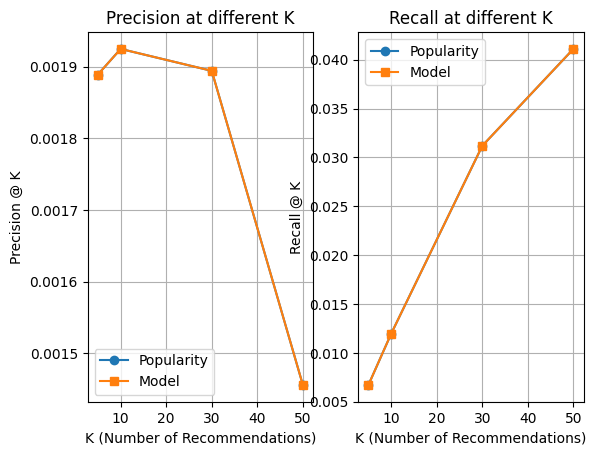

In [49]:
import matplotlib.pyplot as plt
import numpy as np

def evaluate_range(pred_fun, test_data, k_values=[5, 10, 30, 50]):
    precisions = []
    recalls = []
    for k in k_values:
        ps = []
        rs = []
        for user, history in test_data.items():
            actual_items = [item for item, ts in history]
            predictions = pred_fun(user)
            precision, recall = calculate_metrics(predictions, actual_items, k)
            ps.append(precision)
            rs.append(recall)
        precisions.append(np.mean(ps))
        recalls.append(np.mean(rs))

    return precisions, recalls

k_vals = [5, 10, 30, 50]
p1s, r1s = evaluate_range(predict_most_popular, test_histories, k_vals)
p2s, r2s = evaluate_range(predict_most_popular, test_histories, k_vals)

plt.subplot(1, 2, 1)
plt.plot(k_vals, p1s, marker='o', label='Popularity')
plt.plot(k_vals, p2s, marker='s', label='Model')
plt.xlabel('K (Number of Recommendations)')
plt.ylabel('Precision @ K')
plt.title('Precision at different K')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_vals, r1s, marker='o', label='Popularity')
plt.plot(k_vals, r2s, marker='s', label='Model')
plt.xlabel('K (Number of Recommendations)')
plt.ylabel('Recall @ K')
plt.title('Recall at different K')
plt.legend()
plt.grid(True)

plt.show()

## 5. Related Work

Our project fits into a long line of research on systems that suggest items to users based on
their past behavior, such as likes or clicks, and on using image information to make better
recommendations.

**Using past likes and clicks to make recommendations:**  
Many existing systems only see whether a user clicked or liked something, not a detailed
rating. Early work such as *Collaborative Filtering for Implicit Feedback Datasets* (Hu,
Koren, & Volinsky, 2008) and *BPR: Bayesian Personalized Ranking from Implicit
Feedback* (Rendle, Freudenthaler, Gantner, & Schmidt-Thieme, 2009) showed how to use
this kind of “yes/no” data to learn which users and items go well together. Their models
learn a small list of numbers for each user and for each item, and then give a higher score
to user–item pairs whose numbers line up well. At prediction time, the system picks the
items with the highest scores for each user. Our main interaction based model is inspired by this
same idea, where for each user and each project, we learn a short numeric description, and to
recommend projects to a user we score all projects and keep the ones with the highest
scores.

**Popularity based recommendations:**  
Other work on sites like YouTube, Pinterest, or Behance-style platforms has found that
simply recommending the most popular items, meaning the ones that receive the most likes overall,
can already work surprisingly well. Because many users interact with only a few items, and
because attention is often focused on a small set of very popular items, “recommend what
is globally popular” is commonly used as a simple starting point or a backup strategy. Our
popularity based model follows this idea, since we rank projects by how many likes they
have, and recommend the top ones to everyone. In our results, this approach is quite effective: 
on average, for each user, a large fraction of the top 10 projects we recommend
this way are projects they actually liked in the held out test data. This supports the claim
from prior work that likes tend to be heavily concentrated on a small set of very popular
projects.

**Using image information to make recommendations:**  
More recent research combines interaction data with information extracted from the images
themselves. In domains like fashion, art, and design, how something looks is very important,
so using image information can help. Models such as VBPR (*VBPR: Visual Bayesian
Personalized Ranking for Personalized Recommendation of Visual Content*; He &
McAuley, 2016) use an image recognition network to turn each image into a long vector of
numbers that captures aspects like style, color, and composition. They then combine this
image based description with the interaction based model so that the system can
recommend items that both match a user’s taste and look similar to things they have liked
before, and can still recommend reasonable items even when there are few past likes for a
given item. Other work on image popularity prediction, such as *What Makes an Image
Popular?* (Khosla, Das Sarma, & Hamid, 2014), also shows that these kinds of image
features are strongly related to whether an image will attract attention and engagement.

Our visual only model is closest to this line of work on image popularity. In our case, we
ignore user IDs and only look at image-based features, since we build a visual profile for each
user by averaging the image features of the projects they liked, and then recommend
projects whose image features are similar to that profile. We find that this image only
approach does contain useful information, but it is not enough by itself: compared to our
interaction-based model and our popularity based model, it suggests fewer projects that
the user actually likes near the top of the ranked list.

**Combining interaction and image information:**  
A common idea in related works is to combine these different signals rather than choose
only one of them. Many papers use a weighted combination of a score based on past
interactions and a score based on content, such as image features. This lets the system
balance between “people who liked X also liked Y” and “this looks similar to what you
liked before,” and can help especially for users or items that do not have much interaction
history. Our combined model follows this pattern, as for each user–project pair, we compute
one score from the interaction based model and one from the image based model, and
then take a weighted average of the two, controlled by a parameter that decides how much
weight to give to each source of information. In line with prior work, we see that using a
middle value for this weight, rather than relying purely on interactions or purely on images,
gives the best overall ranking of projects for most users on our test data. However, our
results also show that the pure popularity based model still gives the largest number of
correct hits in the top 10 recommendations. This suggests that our simple way of combining
signals does not yet fully exploit popularity information, a limitation that is also discussed in
recent work on how to correctly handle very popular items when building recommendation
systems.
